In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import sys
import importlib

In [2]:
# load own functions
sys.path.append('../') # add path of parent directory to find the functions folder
from functions import plotting, simulation, inference

In [3]:
# set seabron style and matplotlib parameters for very nice plotting
sns.set_style('whitegrid')
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = [10,6]
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['axes.edgecolor'] = 'black'
# mpl.rcParams.keys()

In [4]:
# define random number generator (rng)
rng = np.random.default_rng(seed=1887)

In [6]:
# load posteriors -> SELECT RIGHT PATH DEPENDING ON OS!
# path = '/Volumes/T7/Pacman_Pickle/' # iOS
path = 'E:Pacman_Pickle/' # Windows

# <font color=#005EB8>Parameter Recovery based on Simulated Choices for Y-Navigation Task (Y-NAT)</font>
This notebook uses the Y-NAT to simulate choices for parameter recovery of the four candidate computational models.

### Preparatory work: Load task structure and expected trial rewards for each sequence of actions
<code>dfTask</code> contains the structure of the Y-NAT, including: block number, trial number, and indicator for trials with probabilistic bonus reward.

<code>dfRewards</code> contains the expected rewards (rows: trials) for each sequence of actions (columns).

<code>sequences</code> contains the moves of all possible sequences (N=36)

In [7]:
# load df with task structure
dfTask = pd.read_csv('../data_task/task_structure.csv', usecols=['block', 'trial', 'bonus'])

# load df with expected trial rewards for each sequence of actions (incl. probabilistic bonus for DAS)
dfRewards = pd.read_csv('../data_task/trial_sequence_rewards.csv', header=None)

# load features of possible sequences
f = open('../data_task/sequences.pkl', 'rb')
sequences = pickle.load(f) #, sequencesPositions
f.close()

# define index of default action sequence (DAS)
idxDAS = 4

# <font color=#D28140>1) Expected value with proxy and repetition bias model (EVPRM)</font>

This part performs parameter recovery for EVPRM. The simulation and subsequent inference needs the task structure (<code>dfTask</code>, i.e. block and trial numbers) and the expected rewards for each action at each trial (<code>dfRewards</code>).

This model has three free parameters:
- $\beta$ (precision on expected rewards)
- $R_0$ (approximated reward for unobserved sequences)
- $h=\alpha_{\text{init}}^{-1}$ (repetition bias)

#### Set number of simulated agents and free parameters

In [66]:
# how many agents per parameter combination
numberAgents = 5

# set free parameters
# repetition bias h -> h=1/alpha_init
hs = np.array([.01, .03, .1, .3, 1]) # values based on Schwöbel et al. (2021)

# precision on expected rewards beta
betas = np.array([0.5, 1, 2, 5, 10])

# approximated reward R0
R0s = np.arange(30,110,10)

# get all combinations of the free parameters and repeat for number of agents
# get all combinations of the three free parameters
grid1, grid2, grid3 = np.meshgrid(hs, betas, R0s, indexing='ij')
allCombinations = np.vstack([grid1.ravel(), grid2.ravel(), grid3.ravel()]).T
allCombinations = np.hstack([np.arange(len(allCombinations))[:, np.newaxis], allCombinations]) # add parameter combination ID

print(f'Number of different parameter combinations: {len(allCombinations)}')

# repeat it to get the number of agents per combination and tranform it into a panda
allCombinations = np.tile(allCombinations, numberAgents).reshape(-1, 4)
dfParameterValues = pd.DataFrame(allCombinations, columns=['ID', 'h', 'beta', 'R0'])

# add some noise
dfParameterValues['h'] += rng.normal(size=len(dfParameterValues), scale=dfParameterValues['h']/5)
dfParameterValues['h'] = dfParameterValues['h'].clip(upper=1) # maximum of h is 1
dfParameterValues['beta'] += rng.normal(size=len(dfParameterValues), scale=dfParameterValues['beta']/5)
dfParameterValues['R0'] += rng.normal(size=len(dfParameterValues), scale=2)

print(f'Number of agents: {len(dfParameterValues)}')

Number of different parameter combinations: 200
Number of agents: 1000


### Simulation

In [ ]:
# simulate task with each parameter combination (-> returns series of dfs)
simulationEVPRM = dfParameterValues.apply(lambda row: simulation.simulate_task_EVPRM(dfRewards.to_numpy(),  dfTask['block'], idxDAS,
                                                                  row['beta'], row['R0'], row['h']), axis=1)

### Inference (Parameter Recovery)
Infer parameters of agents with the same parameter combination at once.

In [ ]:
iDataEVPRM = inference.inference_parameter_recovery(dfParameterValues, simulationEVPRM,  inference.inference_EVPRM_group, dfRewards, idxDAS)

### Save Inference Results

In [ ]:
# save inference data objects, the parameter combinations, and the simulation
f = open('PR_EVPRM.pkl', 'wb')
pickle.dump(iDataEVPRM, f) # inference data
pickle.dump(dfParameterValues, f) # used parameter combinations
pickle.dump(simulationEVPRM, f) # simulated data
f.close()

### Plot Results

In [51]:
# load posteriors, true parameters, and simulated choices
f = open(f'{path}PR_EVPRM.pkl', 'rb')
iDataEVPRM = pd.read_pickle(f) 
dfParameterValues = pd.read_pickle(f)
simulationEVPRM = pd.read_pickle(f)
f.close()

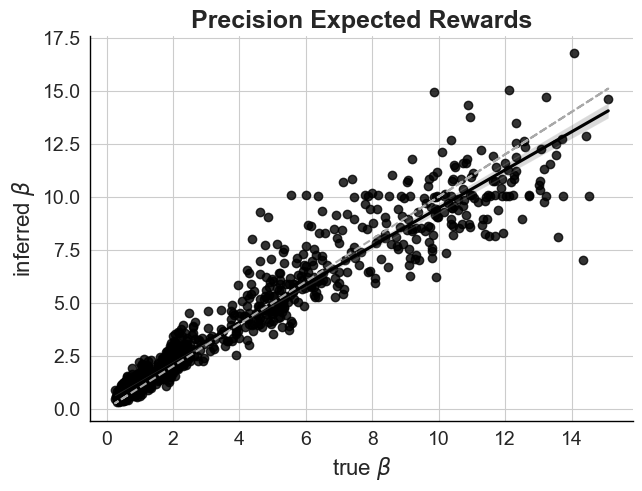

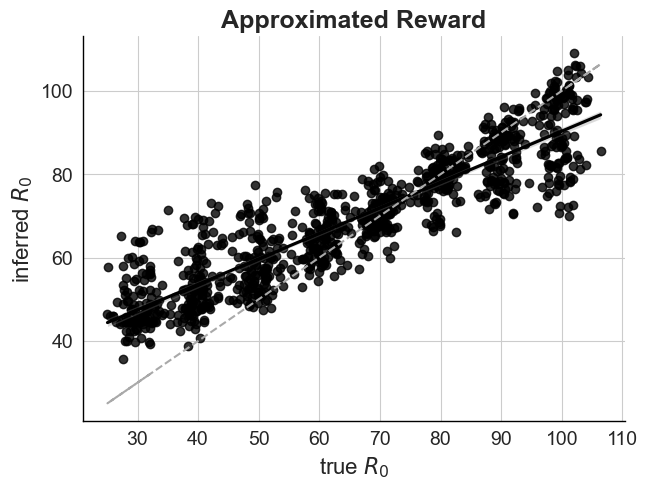

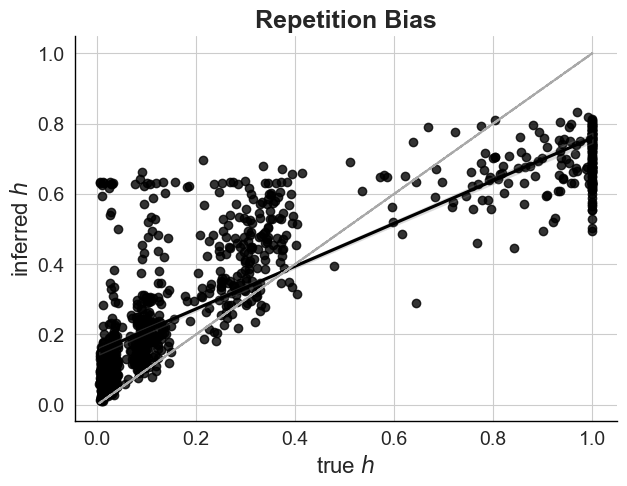

In [54]:
modelName= 'EVPRM'
parameterNamesLatex = [r'$\beta$', r'$R_0$', r'$h$']
parameterNames = ['Precision Expected Rewards', 'Approximated Reward', 'Repetition Bias']

plotting.plot_parameter_recovery(iDataEVPRM, dfParameterValues, parameterNamesLatex, parameterNames, modelName)

# <font color=#D28140>2) Expected Value with Proxy and Default Bias Model (EVPBM)</font>
This part performs parameter recovery for EVPBM. The simulation and subsequent inference needs the task structure (<code>dfTask</code>, i.e. block and trial numbers) and the expected rewards for each action at each trial (<code>dfRewards</code>).

This model has three free parameters:
- $\beta$ (precision on expected rewards)
- $R_0$ (approximated reward for unobserved sequences)
- $b_{\text{DAS}}$ (fixed bias for DAS)

#### Set number of simulated agents and free parameters

In [63]:
# how many agents per parameter combination
numberAgents = 5

# set free parameters
# precision on expected rewards beta
betas = np.array([0.5, 1, 2, 5, 10])

# approximated reward R0
R0s = np.arange(30,110,10)

# fixed bias for DAS
bias = np.arange(5,55,10)

# get all combinations of the free parameters and repeat for number of agents
# get all combinations of the three free parameters
grid1, grid2, grid3 = np.meshgrid(betas, R0s, bias, indexing='ij')
allCombinations = np.vstack([grid1.ravel(), grid2.ravel(), grid3.ravel()]).T
allCombinations = np.hstack([np.arange(len(allCombinations))[:, np.newaxis], allCombinations]) # add parameter combination ID

print(f'Number of different parameter combinations: {len(allCombinations)}')

# repeat it to get the number of agents per combination and tranform it into a panda
allCombinations = np.tile(allCombinations, numberAgents).reshape(-1, 4)
dfParameterValues = pd.DataFrame(allCombinations, columns=['ID', 'beta', 'R0', 'bias'])

# add some noise
dfParameterValues['bias'] += rng.normal(size=len(dfParameterValues), scale=1)
dfParameterValues['beta'] += rng.normal(size=len(dfParameterValues), scale=dfParameterValues['beta']/5)
dfParameterValues['R0'] += rng.normal(size=len(dfParameterValues), scale=2)

print(f'Number of agents: {len(dfParameterValues)}')

Number of different parameter combinations: 200
Number of agents: 1000


### Simulation

In [ ]:
# simulate task with each parameter combination (-> returns series of dfs)
simulationEVPBM = dfParameterValues.apply(lambda row: simulation.simulate_task_EVPBM(dfRewards.to_numpy(),  dfTask['block'], idxDAS,
                                                                  row['beta'], row['R0'], row['bias']), axis=1)

### Inference

In [ ]:
iDataEVPBM = inference.inference_parameter_recovery(dfParameterValues, simulationEVPBM,  inference.inference_EVPBM_group, dfRewards, idxDAS)

### Save Inference Results

In [ ]:
# save inference data objects, the parameter combinations, and the simulation
f = open('PR_EVPBM.pkl', 'wb')
pickle.dump(iDataEVPBM, f) # inference data
pickle.dump(dfParameterValues, f) # used parameter combinations
pickle.dump(simulationEVPBM, f) # simulated data
f.close()

### Plot Results

In [27]:
# load posteriors, true parameters, and simulated choices
f = open(f'{path}PR_EVPBM.pkl', 'rb')
iDataEVPBM = pd.read_pickle(f) 
dfParameterValues = pd.read_pickle(f)
simulationEVPBM = pd.read_pickle(f)
f.close()

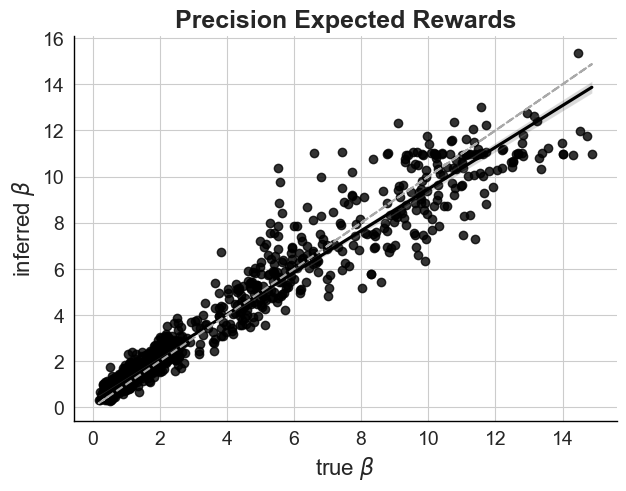

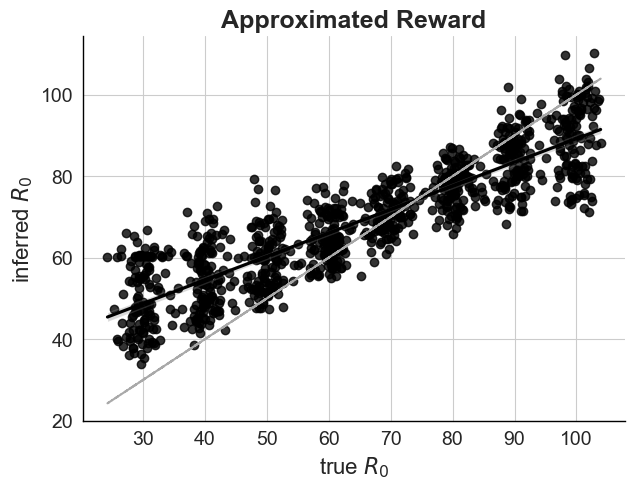

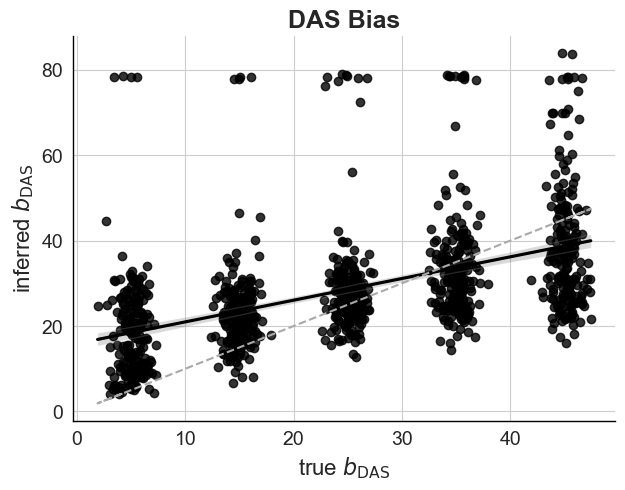

In [50]:
parameterNamesLatex = [r'$\beta$', r'$R_0$', r'$b_{\text{DAS}}$']
parameterNames = ['Precision Expected Rewards', 'Approximated Reward', 'DAS Bias']
modelName = 'EVPBM'

plotting.plot_parameter_recovery(iDataEVPBM, dfParameterValues, parameterNamesLatex, parameterNames, modelName)

# <font color=#D28140>3) Expected Value with Proxy Model (EVPM)</font>
This part performs parameter recovery for EVPM. The simulation and subsequent inference needs the task structure (<code>dfTask</code>, i.e. block and trial numbers) and the expected rewards for each action at each trial (<code>dfRewards</code>).

This model has two free parameters:
- $\beta$ (precision on expected rewards)
- $R_0$ (approximated reward for unobserved sequences)

#### Set number of simulated agents and free parameters

In [64]:
# how many agents per parameter combination
numberAgents = 5

# set free parameters
# precision on expected rewards beta
betas = np.array([0.5, 1, 2, 5, 10])

# approximated reward R0
R0s = np.arange(30,110,10)

# get all combinations of the free parameters and repeat for number of agents
# get all combinations of the three free parameters
grid1, grid2 = np.meshgrid(betas, R0s, indexing='ij')
allCombinations = np.vstack([grid1.ravel(), grid2.ravel()]).T
allCombinations = np.hstack([np.arange(len(allCombinations))[:, np.newaxis], allCombinations]) # add parameter combination ID

print(f'Number of different parameter combinations: {len(allCombinations)}')

# repeat it to get the number of agents per combination and tranform it into a panda
allCombinations = np.tile(allCombinations, numberAgents).reshape(-1, 3)
dfParameterValues = pd.DataFrame(allCombinations, columns=['ID', 'beta', 'R0'])

# add some noise
dfParameterValues['beta'] += rng.normal(size=len(dfParameterValues), scale=dfParameterValues['beta']/5)
dfParameterValues['R0'] += rng.normal(size=len(dfParameterValues), scale=2)

print(f'Number of agents: {len(dfParameterValues)}')

Number of different parameter combinations: 40
Number of agents: 200


### Simulation

In [ ]:
# simulate task with each parameter combination (-> returns series of dfs)
simulationEVPM = dfParameterValues.apply(lambda row: simulation.simulate_task_EVPBM(dfRewards.to_numpy(),  dfTask['block'], idxDAS,
                                                                  row['beta'], row['R0']), axis=1)

### Inference

In [ ]:
iDataEVPM = inference.inference_parameter_recovery(dfParameterValues, simulationEVPM,  inference.inference_EVPM_group, dfRewards, idxDAS)

### Save Inference Results

In [ ]:
# save inference data objects, the parameter combinations, and the simulation
f = open('PR_EVPM.pkl', 'wb')
pickle.dump(iDataEVPM, f) # inference data
pickle.dump(dfParameterValues, f) # used parameter combinations
pickle.dump(simulationEVPM, f) # simulated data
f.close()

### Plot Results

In [55]:
# load posteriors, true parameters, and simulated choices
f = open(f'{path}PR_EVPM.pkl', 'rb')
iDataEVPM = pd.read_pickle(f) 
dfParameterValues = pd.read_pickle(f)
simulationEVPM = pd.read_pickle(f)
f.close()

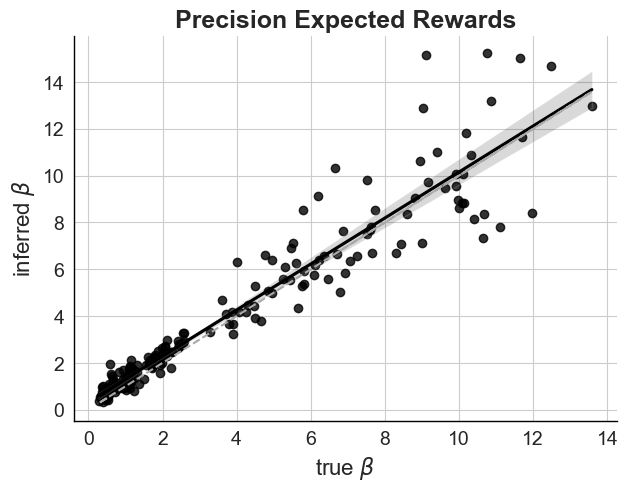

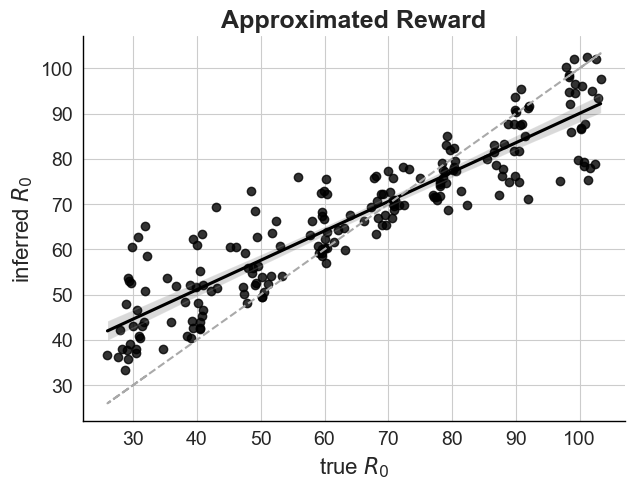

In [56]:
parameterNamesLatex = [r'$\beta$', r'$R_0$']
parameterNames = ['Precision Expected Rewards', 'Approximated Reward']
modelName = 'EVPM'

plotting.plot_parameter_recovery(iDataEVPM, dfParameterValues, parameterNamesLatex, parameterNames, modelName)

# <font color=#D28140>4) Expected Value Model (EVM)</font>
This part performs parameter recovery for EVPM. The simulation and subsequent inference needs the task structure (<code>dfTask</code>, i.e. block and trial numbers) and the expected rewards for each action at each trial (<code>dfRewards</code>).

This model has one free parameters:
- $\beta$ (precision on expected rewards)

#### Set number of simulated agents and free parameters

In [65]:
# how many agents per parameter combination
numberAgents = 5

# set free parameters
# precision on expected rewards beta
betas = np.array([0.5, 1, 2, 5, 10])
betas = np.vstack([np.arange(len(betas)), betas]).T # add ID column

print(f'Number of different parameter combinations: {len(betas)}')

# repeat it to get the number of agents per combination and tranform it into a panda
allCombinations = np.tile(betas, numberAgents).reshape(-1,2)
dfParameterValues = pd.DataFrame(allCombinations, columns=['ID', 'beta'])

# add some noise
dfParameterValues['beta'] += rng.normal(size=len(dfParameterValues), scale=dfParameterValues['beta']/5)

print(f'Number of agents: {len(dfParameterValues)}')

Number of different parameter combinations: 5
Number of agents: 25


### Simulation

In [ ]:
# simulate task with each parameter combination (-> returns series of dfs)
simulationEVM = dfParameterValues.apply(lambda row: simulation.simulate_task_EVM(dfRewards.to_numpy(), dfTask['block'], row['beta']), axis=1)

### Inference

In [ ]:
iDataEVM = inference.inference_parameter_recovery(dfParameterValues, simulationEVM,  inference.inference_EVM_group, dfRewards, idxDAS)

### Save Inference Results

In [ ]:
# save inference data objects, the parameter combinations, and the simulation
f = open('PR_EVM.pkl', 'wb')
pickle.dump(iDataEVM, f) # inference data
pickle.dump(dfParameterValues, f) # used parameter combinations
pickle.dump(simulationEVM, f) # simulated data
f.close()

### Plot Results

In [57]:
# load posteriors, true parameters, and simulated choices
f = open(f'{path}PR_EVM.pkl', 'rb')
iDataEVM = pd.read_pickle(f) 
dfParameterValues = pd.read_pickle(f)
simulationEVM = pd.read_pickle(f)
f.close()

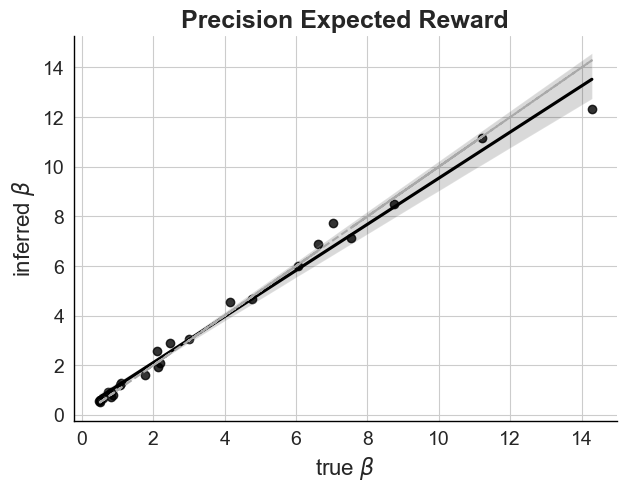

In [59]:
parameterNamesLatex = [r'$\beta$']
parameterNames = ['Precision Expected Reward']
modelName = 'EVM'

plotting.plot_parameter_recovery(iDataEVM, dfParameterValues, parameterNamesLatex, parameterNames, modelName)

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Apr 25 2024

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]
pandas    : 2.1.1
pymc      : 5.9.0
numpy     : 1.25.2
seaborn   : 0.13.0
matplotlib: 3.8.0

Watermark: 2.4.3

